In [1]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install pytorch-forecasting pytorch-lightning scikit-learn matplotlib numpy pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
# two_stage_zero_inflation_tft.py
"""
End-to-end two-stage zero-inflated flood prediction with Temporal Fusion Transformer.
Stage 1: predict flood possibility (binary).
Stage 2: predict flood probability, trained with imbalance sampler.
Inference: final_prob = pi * p.
"""

import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler
import matplotlib.pyplot as plt
import seaborn as sns

from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve

# ------------------ 0. Seed ------------------
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

from torchmetrics import Metric

class BCELossMetric(Metric):
    """
    Wraps nn.BCEWithLogitsLoss as a torchmetrics.Metric so TFT can use it.
    Accumulates per‐batch loss into a global mean.
    """
    full_state_update: bool = False

    def __init__(self, pos_weight=None, reduction="mean"):
        super().__init__()
        # create the actual loss module
        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction=reduction)
        # states for accumulating
        self.add_state("sum_loss", default=torch.tensor(0.0), dist_reduce_fx="sum")
        self.add_state("count",    default=torch.tensor(0),   dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        """
        preds: raw logits from TFT, shape [batch_size, 1]
        target: true labels, same shape
        """
        # ensure shapes match
        preds = preds.view(-1)
        target = target.view(-1).float()
        loss = self.loss_fn(preds, target)
        # accumulate sum and count
        self.sum_loss += loss * target.size(0)
        self.count    += target.size(0)

    def compute(self):
        # return the average loss
        return self.sum_loss / self.count


/media/rohan/c79d22f9-b491-4e0f-8248-6ca5b671d076/major_project2/.venv/lib/python3.12/site-packages/pytorch_forecasting/models/base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [4]:
# ------------------ 1. Load & preprocess data ------------------
# Adjust file path as needed
data = pd.read_csv(
    "/media/rohan/c79d22f9-b491-4e0f-8248-6ca5b671d076/major_project2/rainfall_with_correct_flood_labels.csv"
)
data["TIME"] = pd.to_datetime(data["TIME"])
data["location_id"] = data["LATITUDE"].astype(str) + "_" + data["LONGITUDE"].astype(str)
data = data.sort_values(["location_id", "TIME"]).reset_index(drop=True)
data["time_idx"] = (data["TIME"] - data["TIME"].min()).dt.days
# ensure categorical
for col in ["DISTRICT", "STATE"]:
    data[col] = data[col].astype("category")

# train/validation split
date_cut = int(data["time_idx"].quantile(0.7))
train_df = data[data["time_idx"] <= date_cut]
val_df   = data[data["time_idx"] >  date_cut]

# create binary target for Stage 1
train_df["FLOOD_BINARY"] = (train_df["FLOOD"] > 0).astype(int)
val_df["FLOOD_BINARY"] = (val_df["FLOOD"] > 0).astype(int)

# common params
max_encoder_length    = 90
max_prediction_length = 50
batch_size            = 256


/tmp/ipykernel_223199/1029252975.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["FLOOD_BINARY"] = (train_df["FLOOD"] > 0).astype(int)
/tmp/ipykernel_223199/1029252975.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df["FLOOD_BINARY"] = (val_df["FLOOD"] > 0).astype(int)


In [5]:
# ------------------ 2. Stage 1: Flood Possibility ------------------
training_binary = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    target="FLOOD_BINARY",
    group_ids=["location_id"],
    static_categoricals=["location_id"],
    static_reals=["LATITUDE", "LONGITUDE"],
    time_varying_known_categoricals=["DISTRICT", "STATE"],
    time_varying_known_reals=["RAINFALL"],
    time_varying_unknown_reals=["FLOOD_BINARY"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    target_normalizer=NaNLabelEncoder(),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)
validation_binary = TimeSeriesDataSet.from_dataset(
    training_binary, val_df, predict=True, stop_randomization=True
)
train_loader_bin = training_binary.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
val_loader_bin   = validation_binary.to_dataloader(train=False, batch_size=batch_size, num_workers=4)


In [6]:
# compute positive‐class weight if you like; else leave pos_weight=None
y = train_df["FLOOD_BINARY"].values
counts = np.bincount(y)
pos_weight = torch.tensor(counts[0] / counts[1])

loss=BCELossMetric(pos_weight=pos_weight)

# model and trainer for Stage 1
model_bin = TemporalFusionTransformer.from_dataset(
    training_binary,
    learning_rate=1e-3,
    hidden_size=64,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=16,
    output_size=1,
    loss=BCELossMetric(pos_weight=pos_weight),
    log_interval=10,
    reduce_on_plateau_patience=3,
)
checkpoint1 = ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min", filename="stage1-{epoch:02d}-{val_loss:.4f}")
trainer1 = Trainer(
    max_epochs=20,
    accelerator="auto",
    devices="auto",
    gradient_clip_val=0.1,
    callbacks=[checkpoint1, EarlyStopping(monitor="val_loss", patience=5), LearningRateMonitor()],
)
trainer1.fit(model_bin, train_dataloaders=train_loader_bin, val_dataloaders=val_loader_bin)


/media/rohan/c79d22f9-b491-4e0f-8248-6ca5b671d076/major_project2/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/media/rohan/c79d22f9-b491-4e0f-8248-6ca5b671d076/major_project2/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/media/rohan/c79d22f9-b491-4e0f-8248-6ca5b671d076/major_project2/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been 

Epoch 5: 100%|██████████| 3920/3920 [34:34<00:00,  1.89it/s, v_num=74, train_loss_step=2.070, val_loss=50.60, train_loss_epoch=0.433] 


In [8]:
# ------------------ 3. Stage 2: Flood Probability ------------------
# Use full train_df target FLOOD but oversample floods
y = train_df["FLOOD"].values
counts = np.bincount(y)
pos_weight = counts[0] / counts[1]

training_stage2 = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    target="FLOOD",
    group_ids=["location_id"],
    static_categoricals=["location_id"],
    static_reals=["LATITUDE", "LONGITUDE"],
    time_varying_known_categoricals=["DISTRICT", "STATE"],
    time_varying_known_reals=["RAINFALL"],
    time_varying_unknown_reals=["FLOOD"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    target_normalizer=NaNLabelEncoder(),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)
validation_stage2 = TimeSeriesDataSet.from_dataset(
    training_stage2, val_df, predict=True, stop_randomization=True
)

In [11]:
# Print the first 10 entries of the index to see their structure
for i, idx_tuple in enumerate(training_stage2.index):
    print(i, idx_tuple)
    if i >= 9:
        break


0 time_first
1 time_last
2 time_diff_to_next
3 index_start
4 time
5 count
6 sequence_id
7 index_end
8 sequence_length


In [15]:
# Show the first 10 index tuples (not the DataFrame columns)
print(type(training_stage2.index))
print(training_stage2.index[:5])


<class 'pandas.core.frame.DataFrame'>
   time_first  time_last  time_diff_to_next  index_start  time  count  \
0           0      11484                  1            0     0  11485   
1           0      11484                  1            1     1  11485   
2           0      11484                  1            2     2  11485   
3           0      11484                  1            3     3  11485   
4           0      11484                  1            4     4  11485   

   sequence_id  index_end  sequence_length  
0            0        139              140  
1            0        140              140  
2            0        141              140  
3            0        142              140  
4            0        143              140  


In [16]:
weights2 = []
for i, row in training_stage2.index.iterrows():
    end_idx = row["index_end"]  # already an integer
    lbl = data.iloc[end_idx]["FLOOD"]
    weights2.append(pos_weight if lbl == 1 else 1.0)

sampler2 = WeightedRandomSampler(weights2, num_samples=len(weights2), replacement=True)


In [19]:





# build sampler for Stage2 to oversample flood windows
# ------------------ build sampler for Stage2 to oversample flood windows ------------------

# weights2 = []
# for (start, end) in training_stage2.index:
#     lbl = train_df.iloc[end]["FLOOD"]
#     weights2.append(pos_weight if lbl==1 else 1.0)
# sampler2 = WeightedRandomSampler(weights2, num_samples=len(weights2), replacement=True)
train_loader_stage2 = training_stage2.to_dataloader(train=True, batch_size=batch_size, sampler=sampler2,shuffle=False, num_workers=4)
val_loader_stage2   = validation_stage2.to_dataloader(train=False, batch_size=batch_size, num_workers=4)

model_stage2 = TemporalFusionTransformer.from_dataset(
    training_stage2,
    learning_rate=1e-3,
    hidden_size=64,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=16,
    output_size=1,
    loss=BCELossMetric(pos_weight=torch.tensor(pos_weight)),
    log_interval=10,
    reduce_on_plateau_patience=3,
)
checkpoint2 = ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min", filename="stage2-{epoch:02d}-{val_loss:.4f}")
trainer2 = Trainer(
    max_epochs=20,
    accelerator="auto",
    devices="auto",
    gradient_clip_val=0.1,
    callbacks=[checkpoint2, EarlyStopping(monitor="val_loss", patience=5), LearningRateMonitor()],
)
trainer2.fit(model_stage2, train_dataloaders=train_loader_stage2, val_dataloaders=val_loader_stage2)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | TorchMetricWrapper              | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 3.2 K  | train
3  | prescalers                         | ModuleDict                      | 192    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 9.8 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 10.3 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 7.0 K  | train
7  | static_cont

Epoch 5: 100%|██████████| 3920/3920 [34:45<00:00,  1.88it/s, v_num=75, train_loss_step=0.308, val_loss=43.80, train_loss_epoch=0.429] 


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Best threshold: 0.17, F1: 0.0225
              precision    recall  f1-score   support

           0     0.9929    0.9800    0.9864      6453
           1     0.0153    0.0426    0.0225        47

    accuracy                         0.9732      6500
   macro avg     0.5041    0.5113    0.5045      6500
weighted avg     0.9859    0.9732    0.9795      6500



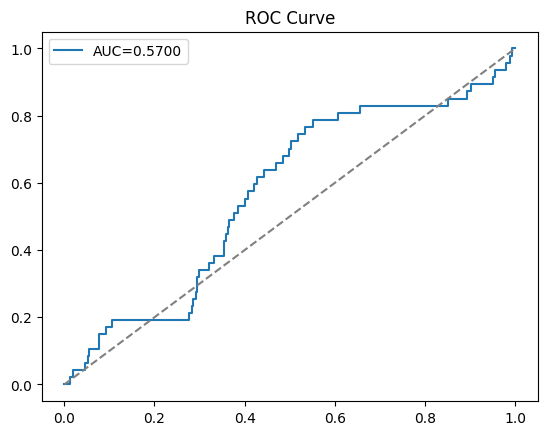

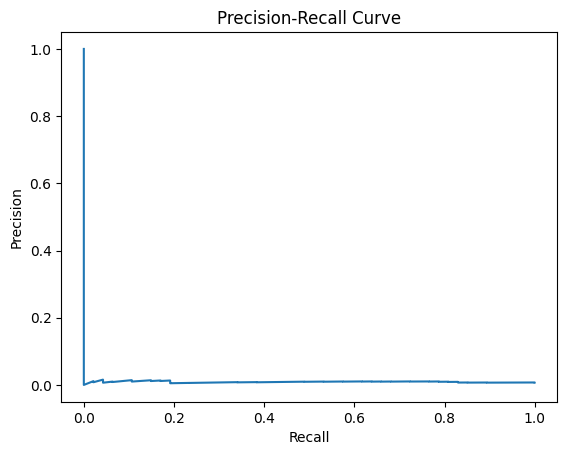

In [ ]:


# ------------------ 4. Inference & Evaluation ------------------

# Stage 1 probabilities → move to CPU → NumPy
raw_pred1 = model_bin.predict(val_loader_bin, mode="prediction")  # torch.Tensor on GPU
pred1     = torch.sigmoid(raw_pred1).flatten().cpu().numpy()

# Stage 2 raw logits → move to CPU → NumPy
raw_pred2 = model_stage2.predict(val_loader_stage2, mode="prediction")  # GPU tensor
pred2     = torch.sigmoid(raw_pred2).flatten().cpu().numpy()

# Final zero‐inflated probability (NumPy arrays)
final_prob = pred1 * pred2

# True labels aligned to Stage 2 windows
predictions2 = model_stage2.predict(val_loader_stage2, mode="raw", return_x=True)
y_true      = predictions2.x["decoder_target"].view(-1).cpu().numpy()

# Threshold tuning
from sklearn.metrics import f1_score, classification_report, roc_curve, precision_recall_curve, roc_auc_score

best_thr, best_f1 = 0.3, 0.0
for thr in np.linspace(0.1, 0.9, 81):
    f1 = f1_score(y_true, (final_prob > thr).astype(int))
    if f1 > best_f1:
        best_f1, best_thr = f1, thr
print(f"Best threshold: {best_thr:.2f}, F1: {best_f1:.4f}")

# Classification report
y_pred = (final_prob > best_thr).astype(int)
print(classification_report(y_true, y_pred, digits=4))

# ROC & PR curves
fpr, tpr, _ = roc_curve(y_true, final_prob)
plt.figure(); plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_true, final_prob):.4f}")
plt.plot([0, 1], [0, 1], "--", color="gray"); plt.legend(); plt.title("ROC Curve"); plt.show()

precision, recall, _ = precision_recall_curve(y_true, final_prob)
plt.figure(); plt.plot(recall, precision); plt.title("Precision-Recall Curve"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.show()



Confusion Matrix:
[[6324  129]
 [  45    2]]


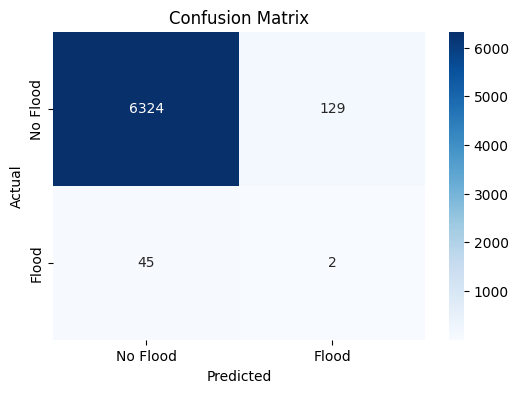

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# y_true: true labels
# y_pred: predicted labels (after thresholding)
cm = confusion_matrix(y_true, y_pred)

# Print it numerically
print("Confusion Matrix:")
print(cm)

# Plot it nicely
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Flood", "Flood"], yticklabels=["No Flood", "Flood"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
